# Building a Spam Filter with Naive Bayes

In this project, we will build a spam filter for SMS messages by classifying messages as spam or non-spam:

* We will Learn how humans classify messages in the dataset
* Use that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
* Classify a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).

So our first task is to "teach" the computer how to classify messages. To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#read in text file dataset
data = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])

#number of rows and columns
data.shape
    

(5572, 2)

In [2]:
data.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
#percentage of spam/ ham
data["Label"].value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

There are 5572 rows and 2 columns, with 87% of the SMS that are ham (non-spam) and 13% that are classified as spam.
___

# Preparing Training set and Testing set

For this project, our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

To test the spam filter, we're first going to split our dataset into two categories:

* A **training set**, which we'll use to "train" the computer how to classify messages.
* A **test set**, which we'll use to test how good the spam filter is with classifying new messages.

We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

* The training set will have 4,458 messages (about 80% of the dataset).
* The test set will have 1,114 messages (about 20% of the dataset).

We're going to start by randomizing the entire dataset to ensure that spam and ham messages are spread properly throughout the dataset

In [4]:
#randomise whole dataset with frac=1, random_state=1 for reproducible results
data_random = data.sample(frac=1, random_state=1)

#split dataset into 80% training set and 20% testing set

#calculate the index number where split takes place
split_index = round(len(data_random) *0.8)

#split data into training set by indexing after split_index, reset_index so the index are ordered
training_set = data_random[:split_index].reset_index(drop=True)

#split data into testing set by indexing before split_index, reset_index so the index are ordered
testing_set = data_random[split_index:].reset_index(drop=True)

#check number of rows in each set is correct
print(training_set.shape)
print(testing_set.shape)



(4458, 2)
(1114, 2)


In [5]:
training_set.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [6]:
testing_set.head()

,Label,SMS
0,ham,Later i guess. I needa do mcat study too.
1,ham,But i haf enuff space got like 4 mb...
2,spam,Had your mobile 10 mths? Update to latest Oran...
3,ham,All sounds good. Fingers . Makes it difficult ...
4,ham,"All done, all handed in. Don't know if mega sh..."


## Percentage of Spam and Ham in each training and test sets
We will now analyze the percentage of spam and ham messages in the training and test sets. We expect the percentages to be close to what we have in the full dataset, where about 87% of the messages are ham, and the remaining 13% are spam.

In [7]:
#find percentage of spam and ham in training set
training_spam_ham = training_set['Label'].value_counts(normalize=True)*100

#find percentage of spam and ham in testing set
testing_spam_ham = training_set['Label'].value_counts(normalize=True)*100

print("training set contains")
print(training_spam_ham)
print("\n")
print("test set contains")
print(testing_spam_ham)

training set contains
ham     86.54105
spam    13.45895
Name: Label, dtype: float64


test set contains
ham     86.54105
spam    13.45895
Name: Label, dtype: float64


Results look satisfactory, we will move on to clean the dataset.
___
# Data Cleaning
## Letter Case and Punctuation

In order to calculate probabilities using our Naive Bayes algorithm, we first need to perform some data cleaning to bring the data into a format that allow us to easily extract the information we need. Take for example the below data:

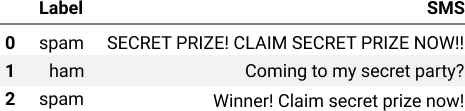


To make the calculations easier, we want to bring the data to this format:

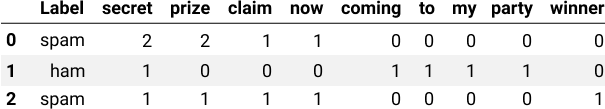

The transformation involves:
* SMS column is being dropped and expanded,
* into individual columns, where each column represent a unique word from the vocabulary.
* each column contains the number of occurence of each unique word in each SMS row
* Lettercases are not differentiated, so "SECRET" and "secret" are considered the same word
* Punctuation are removed 

Let's begin the data cleaning to remove the punctuation and bringing all words to lower case.

In [8]:
# remove punctuation from SMS column, regex '\W' detect any character that is not alphanumeric
training_set["SMS"] = training_set["SMS"].str.replace(r'[\W]', ' ')
testing_set["SMS"] = testing_set["SMS"].str.replace(r'[\W]', ' ')

# bring all words to lower case
training_set["SMS"] = training_set["SMS"].str.lower()
testing_set["SMS"] = testing_set["SMS"].str.lower()

training_set.head()


,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


In [9]:
testing_set.head()

,Label,SMS
0,ham,later i guess i needa do mcat study too
1,ham,but i haf enuff space got like 4 mb
2,spam,had your mobile 10 mths update to latest oran...
3,ham,all sounds good fingers makes it difficult ...
4,ham,all done all handed in don t know if mega sh...


___
# Create the Vocabulary

Let's now move to creating the vocabulary, which in this context means a list with all the unique words in our training set.

In [10]:
#transform each SMS into a list by splitting
training_set["SMS"] = training_set["SMS"].str.split()

#use nested loop through each word of split list to append to a vocabulary list
vocabulary = []

for split_list in training_set["SMS"]:
    for each_word in split_list:
        vocabulary.append(each_word)
        
#transform vocabulary list into a set to remove duplicates in the list
vocabulary = set(vocabulary)

#transform vocabulary set back into list
vocabulary = list(vocabulary)

#check partial list of vocabulary
vocabulary[:10]


    

['sar',
 'extreme',
 'ceiling',
 'gent',
 'haha',
 'balance',
 'videos',
 'meat',
 'r836',
 'gardener']

___
## Final Training Set

Now that we have the list of unique vocabulary, we will now develop the word counts for each unique word found in each row of training set, eventually building a dictionary for a new dataframe.

In [11]:
#initialize a dictionary where each key is a unique word, 
#each value is a list of 0s reflecting number of rows(len) of training set 
#eg. {hello: [0, 0, 0 ... 0], where: [0,0,0 ...0]}
#this will allow each word count to be allocated at same row of sms 

word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

#check keys are in dict
list(word_counts_per_sms.keys())[:3]



['sar', 'extreme', 'ceiling']

In [12]:
#check values of dict
list(word_counts_per_sms.values())[:3]

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


As a reminder, `training_set["SMS"]` is now a list of sms lists after splitting the strings. We will loop over each sms list in `training_set["SMS"]` and with any word found matching the unique word in the `word_counts_per_sms` dictionary, we will add a count to the dictionary at the index position that matches the sms index in the training set. Let's demonstrate how this can method would work.

In [13]:
training_set["SMS"].head()

0                    [yep, by, the, pretty, sculpture]
1    [yes, princess, are, you, going, to, make, me,...
2                      [welp, apparently, he, retired]
3                                             [havent]
4    [i, forgot, 2, ask, ü, all, smth, there, s, a,...
Name: SMS, dtype: object

In [14]:
#demo adding word count to sms index position
demo_sms = [['hello', 'are', 'you', 'where'], ['hello', 'are', 'where', 'where'], ['hello', 'are', 'you', 'where'], 
            ['hello', 'are', 'you', 'where'], ['hello', 'are', 'you', 'where']]

#there are 5 number of 0s paired with each unique word, reflecting the number of sms
demo_dict ={'hello': [0,0,0,0,0], 'are':[0,0,0,0,0], 'you':[0,0,0,0,0], 'where':[0,0,0,0,0]}

#if 'hello' is matched at 1st SMS, add 1 count to index 0
demo_dict['hello'][0] = 1

#if 'where' is matched at 2nd SMS, add 1 count to index 1 
demo_dict['where'][1] = 1

#if 'where' is matched again at 2nd SMS, increment index 1 by 1
demo_dict['where'][1] += 1

demo_dict



{'hello': [1, 0, 0, 0, 0],
 'are': [0, 0, 0, 0, 0],
 'you': [0, 0, 0, 0, 0],
 'where': [0, 2, 0, 0, 0]}

In [15]:
#demo loop
demo_dict2 ={'hello': [0,0,0,0,0], 'are':[0,0,0,0,0], 'you':[0,0,0,0,0], 'where':[0,0,0,0,0]}

#enumerate demo_sms to create index for each sms
#i.e. [(0, ['hello', 'are', 'you', 'where']), (1, ['hello', 'are', 'where', 'where']), .. (4, ['hello', 'are', 'you', 'where'])]
#loop through to extract index and each sms word for saving word count in dictionary
for index, sms in enumerate(demo_sms):
    for word in sms:
        #index allows count to be positioned at the same sms row
        demo_dict2[word][index] +=1

demo_dict2

{'hello': [1, 1, 1, 1, 1],
 'are': [1, 1, 1, 1, 1],
 'you': [1, 0, 1, 1, 1],
 'where': [1, 2, 1, 1, 1]}

We see that the loop above has successfully filled the word counts accurately. Let's apply this for the training set.

In [16]:
for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

#check if 0s have been filled
list(word_counts_per_sms.values())[:3]

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


Ok, we see at least 1 zero has been filled. Let's transform our `word_counts_per_sms` dictionary into a dataframe to better assess our final training dataset.

In [17]:
#transform word_counts_per_sms into dataframe
word_counts_per_sms = pd.DataFrame(word_counts_per_sms)

#concatenate the dataframe with the dataframe containing training set 
#so we will have the 'Label' and 'SMS' columns
final_training_set = pd.concat([training_set, word_counts_per_sms], axis=1)
final_training_set.head()

,Label,SMS,sar,extreme,ceiling,gent,haha,balance,videos,meat,...,match,07946746291,4xx26,ternal,smiling,chiong,annoying,hex,ctter,lovers
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


___
# Calculating Constants First

Now that we're done with data cleaning and have a training set to work with, we can begin creating the spam filter. Using the Naive Bayes algorithm, which is based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable, let's look at what we need in this algorithm:

### Naive Bayes Algorithm

**Probability of Spam given new message** is *proportional* to the product of the probability of Spam and *n* number of *conditional probability* for each word ($w_1, w_2, w_3... w_n$) given it is found in a spam message.
$$
P(Spam|w_1, w_2,..., w_n) \alpha  P(Spam) \cdot \displaystyle\prod_{i=2}^n P(w_i|Spam) 
$$
**Probability of Non-Spam (Ham) given new message** is *proportional* to the the product of the probability of Ham and *n* number of *conditional probability* for each word ($w_1, w_2, w_3... w_n$) given it is found in a ham message.
$$
P(Ham|w_1, w_2,..., w_n) \alpha  P(Ham) \cdot \displaystyle\prod_{i=2}^n P(w_i|Ham) 
$$

### Conditional Probability
$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{vocabulary}}
$$

$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{vocabulary}}
$$


Where

- $N_{w_i|Spam}$ = the number of times the word $w_i$ occurs in spam messages
- $N_{w_i|Ham}$ = the number of times the word $w_i$ occurs in non-spam messages

- $N_{Spam}$ = total number of words in all spam messages
- $N_{Ham}$ = total number of words in all non-spam messages

- $N_{vocabulary}$ = total number of words in the vocabulary
- $\alpha$ = 1 (we will use Laplace smoothing where $\alpha$ = 1)


As a start, let's first calculate the following constants from our training set that will be the same for every new message:

* $P(Spam)$ and $P(Ham)$
* $N_{spam}, N_{ham}, N_{vocabulary}$



In [18]:
# Isolating spam and ham messages first
spam_messages = final_training_set[final_training_set['Label'] == 'spam']
ham_messages = final_training_set[final_training_set['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(final_training_set)
p_ham = len(ham_messages) / len(final_training_set)

# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

print('The probability of spam message is', p_spam)
print('The probability of ham message is', p_ham)
print('We have', n_spam, 'words in all spam messages')
print('We have', n_ham, 'words in all ham messages')
print('We have', n_vocabulary, 'words in our vocabulary')

The probability of spam message is 0.13458950201884254
The probability of ham message is 0.8654104979811574
We have 15190 words in all spam messages
We have 57237 words in all ham messages
We have 7783 words in our vocabulary


## Calculating Parameters

As mentioned earlier, the values calculated in the previous step will have constant values in our equations for every new message (regardless of the message or each individual word in the message).

However, $P(w_i|Spam)$ and $P(w_i|Ham)$ will vary depending on the individual words.
In more technical language, the probability values that $P(w_i|Spam)$ and $P(w_i|Ham)$ will take are called **parameters**.

The fact that we calculate so many values before even beginning the classification of new messages makes the Naive Bayes algorithm very fast (especially compared to other algorithms). When a new message comes in, most of the needed computations are already done, which enables the algorithm to almost instantly classify the new message.

Let's now calculate all the parameters using the conditional proability equations.

$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{vocabulary}}
$$

$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{vocabulary}}
$$

In [19]:
#initiate dictionary to store key-value pair 
# key would be a unique word from our vocabulary,
# value is the parameter - probability for word given spam / ham message
# for every unique key, initiate 0s in value by number(len) of spam/ham messages

spam_parameter = {unique_word: 0 * len(spam_messages) for unique_word in vocabulary}
ham_parameter = {unique_word: 0 * len(ham_messages) for unique_word in vocabulary}

#iterate over vocabulary, for each word calculate probability for word given spam
for word in vocabulary:
    #how many times the word is counted in spam messages
    word_given_spam_count = spam_messages[word].sum()

    #using conditional probability formula, calculate word given spam
    p_word_spam = (word_given_spam_count + alpha) / (n_spam + (alpha * n_vocabulary))
    
    #update probability in spam dictionary
    spam_parameter[word] = p_word_spam

#iterate over vocabulary, for each word calculate probability for word given ham
for word in vocabulary:
    #how many times the word is counted in ham messages
    word_given_ham_count = ham_messages[word].sum()
    
    #using conditional probability formula, calculate word given ham
    p_word_ham = (word_given_ham_count + alpha) / (n_ham + (alpha * n_vocabulary))
    
    #update probability in ham dictionary
    ham_parameter[word] = p_word_ham

_____
# Function to Classify New Message

Now that we've calculated all the constants and parameters we need, we can start creating the spam filter. The spam filter can be understood as a function that:

1) Takes in a string input as a new message $(w_1, w_2, ..., w_n)$, perform some data cleaning such as removing punctuations, lowercase, split strings

2) Calculates $P(Spam|w_1, w_2, ..., w_n)$ and $P(Ham|w_1, w_2, ..., w_n)$

3) Compares the values of $P(Spam|w_1, w_2, ..., w_n)$ and $P(Ham|w_1, w_2, ..., w_n)$, and:

    * If $P(Ham|w_1, w_2, ..., w_n)$ > $P(Spam|w_1, w_2, ..., w_n)$, then the message is classified as ham.

    * If $P(Ham|w_1, w_2, ..., w_n)$ < $P(Spam|w_1, w_2, ..., w_n)$, then the message is classified as spam.
    
    * If $P(Ham|w_1, w_2, ..., w_n)$ = $P(Spam|w_1, w_2, ..., w_n)$, then the algorithm may request human help.
    
To write the code we need for calculating `p_spam_given_message` and `p_ham_given_message`, we need to use these two equations:

### Naive Bayes Algorithm

$$
P(Spam|w_1, w_2,..., w_n) \alpha  P(Spam) \cdot \displaystyle\prod_{i=2}^n P(w_i|Spam) 
$$

$$
P(Ham|w_1, w_2,..., w_n) \alpha  P(Ham) \cdot \displaystyle\prod_{i=2}^n P(w_i|Ham) 
$$

Note that some new messages will contain words that are not part of the vocabulary. For this function, we will ignore these words when we're calculating the probabilities.

We shall proceed to write the code for calculating `p_spam_given_message` and `p_ham_given_message` .

In [20]:
def classify(message):
    # data clean
    message = message.replace(r'[\W]', ' ')
    message = message.lower()
    message = message.split()

    # initiate naive bayes algorithm for loops to multiply spam/ham parameters
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    # message is a list of strings after splitting
    for word in message:
        # if word is a key in spam_parameter dictionary
        if word in spam_parameter:
            # mutiply spam parameter dictionary value
            p_spam_given_message *= spam_parameter[word]

        # if word is a key in ham_parameter dictionary
        if word in ham_parameter:
            # mutiply ham parameter dictionary value
            p_ham_given_message *= ham_parameter[word]
       
         
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal probabilities, have a human classify this!')

In [21]:
#test 1 classify function for obvious spam

classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.0164097981708963e-18
P(Ham|message): 1.8195638182330266e-19
Label: Spam


In [22]:
#test 2 classify function for obvious ham

classify("Sounds good, Tom, then see u there")

P(Spam|message): 5.359472501724851e-18
P(Ham|message): 2.8089018273976984e-14
Label: Ham


We see that our classify function works for the 2 test for spam and ham. We shall proceed to determine how well the spam filter does on our test set of 1,114 messages.
____
## Checking accuracy of spam filter

First off, we'll change the `classify()` function that we wrote previously to return the labels instead of printing them. Below, note that we now have return statements instead of print() functions:

In [23]:
def classify_test_set(message):

    message = message.replace(r'[\W]', ' ')
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in spam_parameter:
            p_spam_given_message *= spam_parameter[word]
        if word in ham_parameter:
            p_ham_given_message *= ham_parameter[word]
       
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'

Now that we have a function that returns labels instead of printing them, we can use it to create a new column in our test set.

In [24]:
testing_set['predicted'] = testing_set['SMS'].apply(classify_test_set)
testing_set.head()


,Label,SMS,predicted
0,ham,later i guess i needa do mcat study too,ham
1,ham,but i haf enuff space got like 4 mb,ham
2,spam,had your mobile 10 mths update to latest oran...,spam
3,ham,all sounds good fingers makes it difficult ...,ham
4,ham,all done all handed in don t know if mega sh...,ham


Now we can compare the predicted values with the actual values to measure how good our spam filter is with classifying new messages. To make the measurement, we'll use **accuracy** as a metric:

**Accuracy = 
number of correctly classified messages / 
total number of classified messages**


In [25]:
#initiate a variable `correct` to store number of correctly classified messages
correct = 0
total = len(testing_set)

#iterate over testing set df, for each row if actual label is same as predicted
#then increment `correct` by 1

for i in range(1114):
    if testing_set.iloc[i,0] == testing_set.iloc[i,2]:
        correct += 1

#measure accuracy by dividing `correct` over `total`
accuracy = correct / total

print('Correct:', correct)
print('Incorrect:', total- correct)
print('Accuracy:', accuracy*100, '%')



Correct: 1100
Incorrect: 14
Accuracy: 98.74326750448833 %


We are yielding an accuracy of about 98% for the spam filter, which is really good. Where only 14 out of 1,114 messages are incorrect, our spam filter has classified 1,100 correctly.

## Next Steps: check incorrect classifications

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set we used, which is a pretty good result. Our initial goal was an accuracy of over 80%, and we managed to do way better than that.

To find out why was the 14 messages classified incorrectly, let's analyse these 14 messages in detail and perhaps we can finetune our algorithm to make it better.



In [26]:
#identifying 14 messages index that were incorrect

incorrect_index = []
for i in range(1114):
    if testing_set.iloc[i,0] != testing_set.iloc[i,2]:
        incorrect_index.append(i)
        
incorrect_index

[114, 135, 152, 159, 284, 293, 302, 319, 504, 546, 741, 876, 885, 953]

In [27]:
#segmenting df for these errorneous index
incorrect_df = testing_set.iloc[(incorrect_index),:]
incorrect_df

,Label,SMS,predicted
114,spam,not heard from u4 a while call me now am here...,ham
135,spam,more people are dogging in your area now call...,ham
152,ham,unlimited texts limited minutes,spam
159,ham,26th of july,spam
284,ham,nokia phone is lovly,spam
293,ham,a boy loved a gal he propsd bt she didnt mind...,needs human classification
302,ham,no calls messages missed calls,spam
319,ham,we have sent jd for customer service cum accou...,spam
504,spam,oh my god i ve found your number again i m s...,ham
546,spam,hi babe its chloe how r u i was smashed on s...,ham


Recall that new messages may contain words not found in our vocabulary dictionary and was subsequently ignored in our algorithm calculation. 
The likelihood of such probability omission skewing a message to an incorrect is highly plausible, we may want to check the percentage of words ignored for each of the misclassifed messages.

In [28]:
split_sms = incorrect_df['SMS'].str.split()
incorrect_df['n_words'] = split_sms.apply(len)

split_sms = pd.DataFrame(split_sms)

incorrect_df['words_ignored'] = 0

for index, sms in split_sms.iterrows():
    for split_list in sms:
        for word in split_list:
            if word not in vocabulary:
                incorrect_df['words_ignored'][index]+=1

incorrect_df['words_ignored_percent'] = round(incorrect_df['words_ignored'] / incorrect_df['n_words']*100, 0)

incorrect_df

,Label,SMS,predicted,n_words,words_ignored,words_ignored_percent
114,spam,not heard from u4 a while call me now am here...,ham,33,3,9.0
135,spam,more people are dogging in your area now call...,ham,30,4,13.0
152,ham,unlimited texts limited minutes,spam,4,1,25.0
159,ham,26th of july,spam,3,0,0.0
284,ham,nokia phone is lovly,spam,4,1,25.0
293,ham,a boy loved a gal he propsd bt she didnt mind...,needs human classification,97,0,0.0
302,ham,no calls messages missed calls,spam,5,0,0.0
319,ham,we have sent jd for customer service cum accou...,spam,18,0,0.0
504,spam,oh my god i ve found your number again i m s...,ham,25,3,12.0
546,spam,hi babe its chloe how r u i was smashed on s...,ham,33,1,3.0


Text(0.5, 1.0, 'Percentage of words not included in probability calculation')

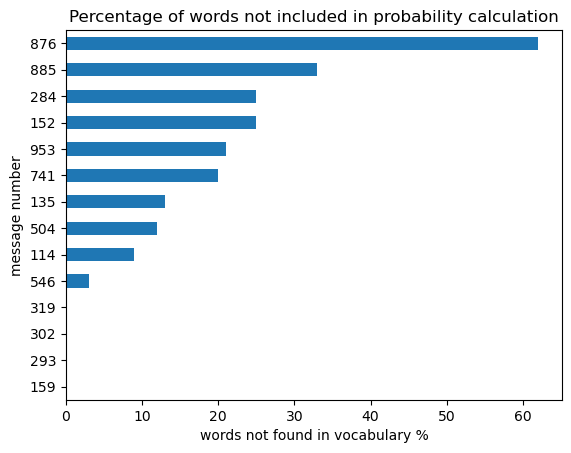

In [29]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

incorrect_df.sort_values(by='words_ignored_percent', ascending=True).plot(kind='barh', y='words_ignored_percent')
plt.xlabel('words not found in vocabulary %')
plt.ylabel('message number')
plt.legend("", frameon=False)
plt.title('Percentage of words not included in probability calculation')

Out of the 14 incorrect predictions, 
* we see that 4 messages (319, 302, 293, 159) have no words ignored, out of which we know 293 requires human classificaion so we will only look into the detail of 319, 302 and 159.
* 10 messages have words not found in our vocabulary, which may be the reason why the probabilities are skewed towards certain higher probability words. We will not check these further as we will not be able to classify them without more training data.

## Message 319: Incorrect Spam prediction instead of Ham

In [30]:
#checking index 319 for words used in spam

#reset index of incorrect df
reset_incorrect_df = incorrect_df.reset_index()
reset_incorrect_df 

,index,Label,SMS,predicted,n_words,words_ignored,words_ignored_percent
0,114,spam,not heard from u4 a while call me now am here...,ham,33,3,9.0
1,135,spam,more people are dogging in your area now call...,ham,30,4,13.0
2,152,ham,unlimited texts limited minutes,spam,4,1,25.0
3,159,ham,26th of july,spam,3,0,0.0
4,284,ham,nokia phone is lovly,spam,4,1,25.0
5,293,ham,a boy loved a gal he propsd bt she didnt mind...,needs human classification,97,0,0.0
6,302,ham,no calls messages missed calls,spam,5,0,0.0
7,319,ham,we have sent jd for customer service cum accou...,spam,18,0,0.0
8,504,spam,oh my god i ve found your number again i m s...,ham,25,3,12.0
9,546,spam,hi babe its chloe how r u i was smashed on s...,ham,33,1,3.0


In [31]:
#split message 319
split_319 = reset_incorrect_df.iloc[7,2].split()

#repeated words are saved once only, so number of keys in dictionary does not represent number of words in original sms
match_ham_319 = {}
for word in split_319:
    if word in ham_parameter:
        match_ham_319[word] = ham_parameter[word]
        
match_spam_319 = {}
for word in split_319:
    if word in spam_parameter:
        match_spam_319[word] =spam_parameter[word]

print('ham probability:', match_ham_319)
print('spam probability:', match_spam_319)

ham probability: {'we': 0.004490925868963396, 'have': 0.0055059981544140265, 'sent': 0.0007689941556444171, 'jd': 3.075976622577668e-05, 'for': 0.006336511842509997, 'customer': 0.0001076591817902184, 'service': 4.6139649338665025e-05, 'cum': 0.0001076591817902184, 'accounts': 3.075976622577668e-05, 'executive': 3.075976622577668e-05, 'to': 0.01959397108581975, 'ur': 0.0030913565056905567, 'mail': 0.00033835742848354353, 'id': 0.00023069824669332513, 'details': 0.00024607812980621346, 'contact': 0.00015379883112888343, 'us': 0.0007536142725315288}
spam probability: {'we': 0.0017411744221477387, 'have': 0.004875288382013668, 'sent': 0.00030470552387585427, 'jd': 4.3529360553693465e-05, 'for': 0.006703521525268794, 'customer': 0.0017411744221477387, 'service': 0.0020023505854698995, 'cum': 0.0002611761633221608, 'accounts': 4.3529360553693465e-05, 'executive': 4.3529360553693465e-05, 'to': 0.023810560222870324, 'ur': 0.005092935184782136, 'mail': 4.3529360553693465e-05, 'id': 0.000174117

Since we have the probabilities of each word in the sms, it may be interesting to compare ham and spam probability for each word to see if there is any pattern of any specific word pushing the overall probability towards spam/ham.

In [32]:
#combine both ham and spam dataframe
ham_df319 = pd.DataFrame(match_ham_319.items(), columns=['Word', 'Ham_Probability'])
spam_df319 = pd.DataFrame(match_spam_319.items(), columns=['Word', 'Spam_Probability'])

all_319 = ham_df319.merge(spam_df319)
all_319

,Word,Ham_Probability,Spam_Probability
0,we,0.004491,0.001741
1,have,0.005506,0.004875
2,sent,0.000769,0.000305
3,jd,0.000031,0.000044
4,for,0.006337,0.006704
5,customer,0.000108,0.001741
6,service,0.000046,0.002002
7,cum,0.000108,0.000261
8,accounts,0.000031,0.000044
9,executive,0.000031,0.000044


Text(0, 0.5, 'word probability')

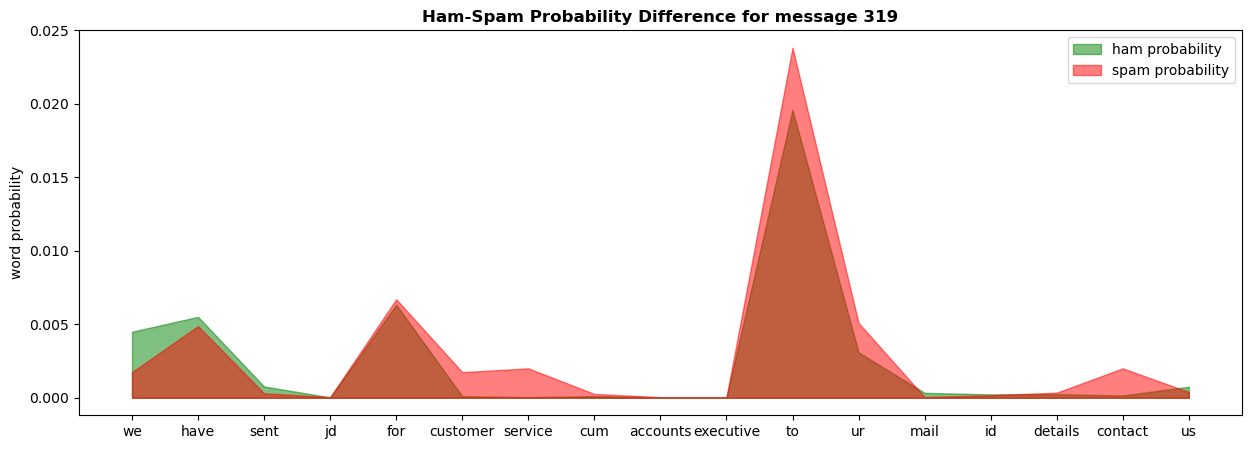

In [33]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

#plot differences for 319
plt.figure(figsize=(15,5))
plt.fill_between(all_319['Word'], all_319['Ham_Probability'], color="g",
                 alpha=0.5, label='ham probability')
plt.fill_between(all_319['Word'], all_319['Spam_Probability'], color="r",
                 alpha=0.5, label='spam probability')               
plt.legend()
    
#plot title
plt.title('Ham-Spam Probability Difference for message 319', fontweight='bold')
    
# #plot labels
plt.ylabel('word probability')

Interestingly, the word `to` is generating a huge tip over to *spam* classification almost four times more impactful than another similar word like `for`. This is followed by `service`, `ur`, `contact` and `customer` which is just as likely to be found in a *ham* message if this is classified by human. 

Let's look at the rest of the mis-classifications to see if we find similar patterns.

## Message 302 & 159: Incorrect Spam prediction instead of Ham

In [34]:
def analyse_message(index_number, message_number):
    #split message
    split_message = reset_incorrect_df.iloc[index_number,2].split()

    match_ham = {}
    for word in split_message:
        if word in ham_parameter:
            match_ham[word] = ham_parameter[word]
            
    match_spam = {}
    for word in split_message:
        if word in spam_parameter:
            match_spam[word] =spam_parameter[word]

    #create dataframe for message spam/ham probabilities
    ham_prob_df = pd.DataFrame(match_ham.items(), columns=['Word', 'Ham_Probability'])
    spam_prob_df = pd.DataFrame(match_spam.items(), columns=['Word', 'Spam_Probability'])

    #add ham-spam probabilty difference column
    both_prob_df = ham_prob_df.merge(spam_prob_df)

    return both_prob_df

In [35]:
#analyse message 302, index 6, assign function results to variables 
both_prob_df_302 = analyse_message(6, 302)

Text(0, 0.5, 'word probability')

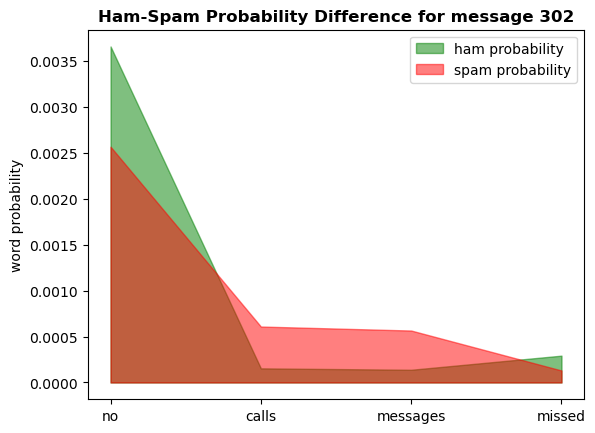

In [36]:
#plot differences for 302
plt.fill_between(both_prob_df_302['Word'], both_prob_df_302['Ham_Probability'], color="g",
                 alpha=0.5, label='ham probability')
plt.fill_between(both_prob_df_302['Word'], both_prob_df_302['Spam_Probability'], color="r",
                 alpha=0.5, label='spam probability')               
plt.legend()
    
#plot title
plt.title('Ham-Spam Probability Difference for message 302', fontweight='bold')
    
# #plot labels
plt.ylabel('word probability')

In [37]:
#message 302 original sms
reset_incorrect_df.iloc[6,2]

'no calls  messages  missed calls'

In [38]:
#message 302 word probabilities
both_prob_df_302

,Word,Ham_Probability,Spam_Probability
0,no,0.003660,0.002568
1,calls,0.000154,0.000609
2,messages,0.000138,0.000566
3,missed,0.000292,0.000131


For message 302, the word `calls` occured twice in the message. This means the probability of `calls` would have increased the probability of spam classification. If we compare the probability calculation for 1 `calls` versus 2 `calls` we may find that it changes the classification.

In [39]:
#message 302 probability with 2 'calls' word found
split_message_302 = reset_incorrect_df.iloc[6,2].split()

p_spam_given_302 = p_spam
p_ham_given_302 = p_ham

for word in split_message_302:
    if word in spam_parameter:
        p_spam_given_302 *= spam_parameter[word]
    if word in ham_parameter:
        p_ham_given_302 *= ham_parameter[word]
       
print(f'Probability of Spam given message 302 with 2 "calls" words is {p_spam_given_302}', 
      f'\nProbability of Ham given message 302 with 2 "calls" words is {p_ham_given_302}')
print(f'Message is a Spam: {p_spam_given_302 > p_ham_given_302}')
print("\n")

#message 302 probability with 1 'calls' word found

p_spam_given_302_1 = p_spam
p_ham_given_302_1 = p_ham

for i, prob in both_prob_df_302['Spam_Probability'].items():
    p_spam_given_302_1*=prob

for i, prob in both_prob_df_302['Ham_Probability'].items():
    p_ham_given_302_1*=prob

print(f'Probability of Spam given message 302 with 1 "calls" word is {p_spam_given_302_1}', 
      f'\nProbability of Ham given message 302 with 1 "calls" word is {p_ham_given_302_1}')
print(f'Message is a Spam: {p_spam_given_302_1 > p_ham_given_302_1}')


Probability of Spam given message 302 with 2 "calls" words is 9.486266328052986e-18 
Probability of Ham given message 302 with 2 "calls" words is 3.0308217891370387e-18
Message is a Spam: True


Probability of Spam given message 302 with 1 "calls" word is 1.5566285453882945e-14 
Probability of Ham given message 302 with 1 "calls" word is 1.9706403272969024e-14
Message is a Spam: False


This is interesting because a seemingly 'harmless' (relatively low probability for either ham or spam) word when used multiple times will also change the classification. 

In [40]:
#analyse message 159, index number 3, assign function results to variables
both_prob_df_159 = analyse_message(3, 159)

Text(0, 0.5, 'word probability')

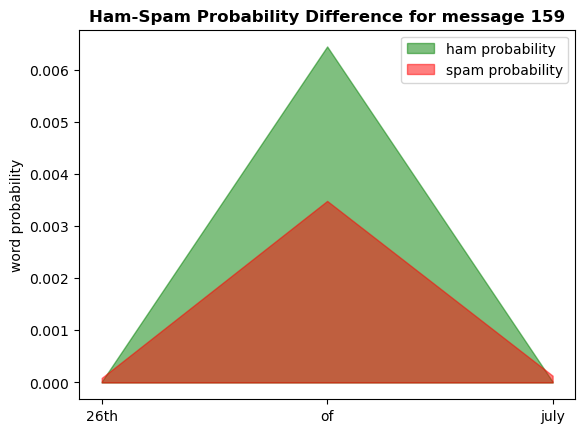

In [41]:
#plot differences for 159
plt.fill_between(both_prob_df_159['Word'], both_prob_df_159['Ham_Probability'], color="g",
                 alpha=0.5, label='ham probability')
plt.fill_between(both_prob_df_159['Word'], both_prob_df_159['Spam_Probability'], color="r",
                 alpha=0.5, label='spam probability')               
plt.legend()
    
#plot title
plt.title('Ham-Spam Probability Difference for message 159', fontweight='bold')
    
# #plot labels
plt.ylabel('word probability')



In [42]:
# message 159 original sms
reset_incorrect_df.iloc[3,2]

'26th of july'

In [43]:
# message 159 word probabilities
both_prob_df_159


,Word,Ham_Probability,Spam_Probability
0,26th,0.000015,0.000087
1,of,0.006444,0.003482
2,july,0.000015,0.000131


For message 159, strangely all words are only used once, with the highest probability tipping towards a `ham` classification. It is of wonder which part of the calculation went wrong, let's check using different combination of the words to see which word's probability might be skewing the results.

In [44]:
#message 159 probability calculated from scratch

word_1_ham = both_prob_df_159['Ham_Probability'][0]
word_2_ham = both_prob_df_159['Ham_Probability'][1]
word_3_ham = both_prob_df_159['Ham_Probability'][2]

word_1_spam = both_prob_df_159['Spam_Probability'][0]
word_2_spam = both_prob_df_159['Spam_Probability'][1]
word_3_spam = both_prob_df_159['Spam_Probability'][2]


p_spam_given_159_1_2 = p_spam *word_1_spam *word_2_spam
p_ham_given_159_1_2 = p_ham *word_1_ham *word_2_ham

if p_spam_given_159_1_2 < p_ham_given_159_1_2:
    print('"26th" + "of" = Ham')
else:
    print('"26th" + "of" = Spam')

print(f'Ham-Spam difference: {p_ham_given_159_1_2 - p_spam_given_159_1_2}')

"26th" + "of" = Ham
Ham-Spam difference: 4.4968008425803494e-08


In [45]:
p_spam_given_159_2_3 = p_spam *word_2_spam *word_3_spam
p_ham_given_159_2_3 = p_ham *word_2_ham *word_3_ham

if p_spam_given_159_2_3 < p_ham_given_159_2_3:
    print('"of" + "July" = Ham')
else:
    print('"of" + "July" = Spam')

print(f'Ham-Spam difference: {p_ham_given_159_2_3 - p_spam_given_159_2_3}')

"of" + "July" = Ham
Ham-Spam difference: 2.4566337037233426e-08


In [46]:
p_spam_given_159_1_3 = p_spam *word_1_spam *word_3_spam
p_ham_given_159_1_3 = p_ham *word_1_ham *word_3_ham

if p_spam_given_159_1_3 < p_ham_given_159_1_3:
    print('"26th" + "July" = Ham')
else:
    print('"26th" + "July" = Spam')

print(f'Ham-Spam difference: {p_ham_given_159_1_3 - p_spam_given_159_1_3}')

"26th" + "July" = Spam
Ham-Spam difference: -1.3254204586703358e-09


It seems that the combination of `26th` and `July` words are skewing the probability towards `Spam`. However if we look at ham-spam difference for this combination, as compared to the other combinations, it is a miniscule 0.000000001325 that pushes it towards `Spam`. There is no explanation to why these 2 words have higher probabilities for `spam`, but we can see that the short length of sms seems to be more susceptible to outliers as a small probability difference can easily skew the overall results.

____
# Conclusion

While our predictive algorithm has a 98% accuracy, we find that there are still some limitations to this method of classification:
- The training set may not be large enough to identify all possible spam/ham words, and the lack of missing probabilities can skew the classification. 
- Certain connecting words like `to` or words that require dependence on context (as seen in message 319) may incorrectly skew the classification.
- Duplicates of words in the same text may increase probability of its classification.
- Short lengths of message may have heavier weight on a single word skewing the overall result.

 These observations tells us that while text classification models are effective to a large extent, there are still outliers that need to be taken care of given the different nuances and context the words will reveal when used together, therefore human classification is still important for counter checking results.